In [ ]:
!pip install -U sentence-transformers

     |████████████████████████████████| 71kB 9.8MB/s 
     |████████████████████████████████| 1.8MB 22.3MB/s 
     |████████████████████████████████| 1.2MB 49.0MB/s 
     |████████████████████████████████| 2.9MB 58.1MB/s 
     |████████████████████████████████| 890kB 55.9MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.4.1.2-cp36-none-any.whl size=103068 sha256=b24543a4227c10251f217f6ebf133d31ed1910f0b618d9a12419ca45be6ee8d8
  Stored in directory: /root/.cache/pip/wheels/3d/33/d1/5703dd56199c09d4a1b41e0c07fb4e7765a84d787cbdc48ac3
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=3922e36c40bc238bcc4535dbe9718eb485c61eb6d0eafcf141d6f0ed7a2ab520
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [ ]:
import pandas as pd
from textblob import TextBlob
import glob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
import numpy as np
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer



In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def text_processing(tweet):
    
    tweet= tweet.lower()
    
    #Removing hyperlinks from the tweet
    tweet_no_links=re.sub(r'http\S+', '', tweet)
    
    #Generating the list of words in the tweet (hashtags and other punctuations removed)
    def form_sentence(tweet):
        tweet_blob = TextBlob(tweet)
        return ' '.join(tweet_blob.words)
    new_tweet = form_sentence(tweet_no_links)
    
    #Removing stopwords and words with unusual symbols
    def no_user_alpha(tweet):
        tweet_list = [ele for ele in tweet.split() if ele != 'user']
        clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
        clean_s = ' '.join(clean_tokens)
        clean_mess = [word for word in clean_s.split() if word not in stopwords.words('english')]
        return clean_mess
    no_punc_tweet = no_user_alpha(new_tweet)
    
    #Normalizing the words in tweets 
    def normalization(tweet_list):
        lem = WordNetLemmatizer()
        normalized_tweet = []
        for word in tweet_list:
            normalized_text = lem.lemmatize(word,'v')
            normalized_tweet.append(normalized_text)
        return " ".join(normalized_tweet)
    
    
    return normalization(no_punc_tweet)

In [ ]:
all_files = glob.glob("./dataset_cleaning/*.pkl")
all_files.sort()
datasets = []

for filename in all_files:
    print(filename)
    df = pd.read_pickle(filename)
    datasets.append(df)
    print(df.Informativeness.value_counts())


./dataset_cleaning/dataset1Cleaned.pkl
1    11717
0     6437
Name: Informativeness, dtype: int64
./dataset_cleaning/dataset2Cleaned.pkl
1    11365
0     4380
Name: Informativeness, dtype: int64
./dataset_cleaning/dataset3Cleaned.pkl
0    1624
1     898
Name: Informativeness, dtype: int64
./dataset_cleaning/dataset4Cleaned.pkl
0    4187
1    3742
Name: Informativeness, dtype: int64
./dataset_cleaning/dataset5Cleaned.pkl
1    535
0    291
Name: Informativeness, dtype: int64
./dataset_cleaning/dataset6Cleaned.pkl
1    17776
0     2325
Name: Informativeness, dtype: int64
./dataset_cleaning/dataset7Cleaned.pkl
0    312
1    177
Name: Informativeness, dtype: int64


In [ ]:
for i,ds in enumerate(datasets):
    print("Processing dataset {}".format(i+1))
    ds['text_processed']=ds['text'].apply(text_processing)

Processing dataset 1
Processing dataset 2
Processing dataset 3
Processing dataset 4
Processing dataset 5
Processing dataset 6
Processing dataset 7


In [ ]:
authors=pd.read_csv('./tweet_metadata_full.csv')
users=pd.read_csv('./twitter_user_full.csv')
authors.drop(columns=['Unnamed: 0'], inplace=True)
users.drop(columns=['Unnamed: 0','created_at', 'lang', 'name', 'screen_name', 'location','access'], inplace=True)
users.columns=['author_id', 'has_description', 'bio_has_url', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'statuses_count', 'protected',
       'verified', 'default_profile', 'default_profile_image']

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
def count_hashtags(text):
    return text.count('#')

In [ ]:
def text_has_slang(text):
    for i in text[:-50].split(' '):
        for j in ['afaik','afk','asl','atm','atw','ayy','bae','bb','bbiab','bbl','bbs','bc','bf','bff','bork','brb','btw','cba','convo','cp','cya','cya','dank','dc','dem','dw','e2e','fml','FOMO','FTFY','ftl','ftw','fwiw','fyi','g2g','g4u','gf','gg','goml','gr8','gratz','gtfo','guiz','hbu','hru','ianadb','ianalb','ianap','idc','idgaf','idk','iirc','ik','ikr','ily','inb4','irl','jfc','jk','js','k','kappa','kek','kms','kthx','l8r','leet','lmao','lmk','lol','LPT','lrl','lrn2','m8','maga','mfw','mrw','nerf','ngl','nm','nmu','noob','nvm','ofc','omf','omg','omw','ooc','op','OP','orly','pepe','pleb','pleb','plz','pron','pwned','REEEEEE','rekt','rickrol','rip','rly','rms','rofl','rotflol','rtfm','rude','shank','smd','smh','soz','swag','tbf','tbh','tbt','TIFU','tf','tfw','thx','tide','TIL','tl;dr','tmw','tolo','topkek','ty','uwotm8','w00t','wb','wot','wtb','wtf','wtg','wts','wuu2','yarly','ymmv','yolo','yw']:
            if(i==j):
                return True
    return False

In [ ]:

def text_has_emoji(text):
    return any(map(text[:-50].__contains__, [':)',':(',':P',':c',':<','c:','<:',':L',':l','^_^','^.^','>_<','>.<','>_>','<_<','>.>','<.<','-.-','-_-','o_o','o.o','._.','owo','OwO',';_;','>:)',':]',':}','>:(','>:|','-.^','-_^','8)','B)','<3','xD',':3','x3','\o','\o/',';_;','OwO','uwu','O:)',':#',':*']))

In [ ]:
def has_profanity(text):
    for i in text[:-50].split(' '):
        for j in ['acrotomophilia','anal','anilingus','anus','arsehole','ass','asshole','assmunch','auto erotic','autoerotic','babeland','baby batter','ball gag','ball gravy','ball kicking','ball licking','ball sack','ball sucking','bangbros','bareback','barely legal','barenaked','bastardo','bastinado','bbw','bdsm','beaver cleaver','beaver lips','bestiality','bi curious','big black','big breasts','big knockers','big tits','bimbos','birdlock','bitch','black cock','blonde action','blonde on blonde action','blow j','blow your l','blue waffle','blumpkin','bollocks','bondage','boner','boob','boobs','booty call','brown showers','brunette action','bukkake','bulldyke','bullet vibe','bung hole','bunghole','busty','butt','buttcheeks','butthole','camel toe','camgirl','camslut','camwhore','carpet muncher','carpetmuncher','chocolate rosebuds','circlejerk','cleveland steamer','clit','clitoris','clover clamps','clusterfuck','cock','cocks','coprolagnia','coprophilia','cornhole','cum','cumming','cunnilingus','cunt','darkie','date rape','daterape','deep throat','deepthroat','dick','dildo','dirty pillows','dirty sanchez','dog style','doggie style','doggiestyle','doggy style','doggystyle','dolcett','domination','dominatrix','dommes','donkey punch','double dong','double penetration','dp action','eat my ass','ecchi','ejaculation','erotic','erotism','escort','ethical slut','eunuch','faggot','fecal','felch','fellatio','feltch','female squirting','femdom','figging','fingering','fisting','foot fetish','footjob','frotting','fuck','fucking','fuck buttons','fudge packer','fudgepacker','futanari','g-spot','gang bang','gay sex','genitals','giant cock','girl on','girl on top','girls gone wild','goatcx','goatse','gokkun','golden shower','goo girl','goodpoop','goregasm','grope','group sex','guro','hand job','handjob','hard core','hardcore','hentai','homoerotic','honkey','hooker','hot chick','how to kill','how to murder','huge fat','humping','incest','intercourse','jack off','jail bait','jailbait','jerk off','jigaboo','jiggaboo','jiggerboo','jizz','juggs','kike','kinbaku','kinkster','kinky','knobbing','leather restraint','leather straight jacket','lemon party','lolita','lovemaking','make me come','male squirting','masturbate','menage a trois','milf','missionary position','motherfucker','mound of venus','mr hands','muff diver','muffdiving','nambla','nawashi','negro','neonazi','nig nog','nigga','nigger','nimphomania','nipple','nipples','nsfw images','nude','nudity','nympho','nymphomania','octopussy','omorashi','one cup two girls','one guy one jar','orgasm','orgy','paedophile','panties','panty','pedobear','pedophile','pegging','penis','phone sex','piece of shit','piss pig','pissing','pisspig','playboy','pleasure chest','pole smoker','ponyplay','poof','poop chute','poopchute','porn','porno','pornography','prince albert piercing','pthc','pubes','pussy','queaf','raghead','raging boner','rape','raping','rapist','rectum','reverse cowgirl','rimjob','rimming','rosy palm','rosy palm and her 5 sisters','rusty trombone','s&m','sadism','scat','schlong','scissoring','semen','sex','sexo','sexy','shaved beaver','shaved pussy','shemale','shibari','shit','shota','shrimping','slanteye','slut','smut','snatch','snowballing','sodomize','sodomy','spic','spooge','spread legs','strap on','strapon','strappado','strip club','style doggy','suck','sucks','suicide girls','sultry women','swastika','swinger','tainted love','taste my','tea bagging','threesome','throating','tied up','tight white','tit','tits','titties','titty','tongue in a','topless','tosser','towelhead','tranny','tribadism','tub girl','tubgirl','tushy','twat','twink','twinkie','two girls one cup','undressing','upskirt','urethra play','urophilia','vagina','venus mound','vibrator','violet blue','violet wand','vorarephilia','voyeur','vulva','wank','wet dream','wetback','white power','women rapping','wrapping men','wrinkled starfish','xx','xxx','yaoi','yellow showers','yiffy','zoophilia']:
            if(i==j):
                return True
    return False

In [ ]:
def is_RT(text):
    for i in text[:-50].split(' '):
        if(i == 'RT' or i.startswith('@')):
            return True
    return False

In [ ]:
mean=['retweet_count','favorite_count','followers_count', 'friends_count', 'listed_count', 'favourites_count', 'statuses_count']
median = ['tweet_type', 'has_description', 'bio_has_url', 'protected', 'verified','default_profile', 'default_profile_image']


for i,ds in enumerate(datasets):
    print("Processing dataset {}".format(i+1))
    ds = pd.merge(ds, authors, on='id', how='left')

    ds.drop(ds.columns.difference(['id', 'Informativeness','text', 'text_processed', 'author_id', 'tweet_type', 'retweet_count', 'favorite_count']), 1, inplace=True)



    ds = pd.merge(ds, users, on='author_id', how='left')


    for m in mean:
        ds[m][ds['Informativeness'] == 1] = ds[m][ds['Informativeness'] == 1].fillna((ds[m][ds['Informativeness'] == 1].mean()))
        ds[m][ds['Informativeness'] == 0] = ds[m][ds['Informativeness'] == 0].fillna((ds[m][ds['Informativeness'] == 0].mean()))

    for m in median:
        ds[m][ds['Informativeness'] == 1] = ds[m][ds['Informativeness'] == 1].fillna((ds[m][ds['Informativeness'] == 1].value_counts().idxmax()))
        ds[m][ds['Informativeness'] == 0] = ds[m][ds['Informativeness'] == 0].fillna((ds[m][ds['Informativeness'] == 0].value_counts().idxmax()))

    ds["has_description"] = ds["has_description"].apply(lambda x: 0 if x is np.nan else 1)
    ds["tweet_type"] = ds["tweet_type"].apply(lambda x: 0 if x =='tweet' else 1)
    ds["bio_has_url"] = ds["bio_has_url"].apply(lambda x: 0 if x is np.nan else 1)

    ds["hashtag_count"]=ds['text'].apply(count_hashtags)
    ds["emoji_present"] = ds['text'].apply(text_has_emoji)
    ds["slang_present"] = ds['text'].apply(text_has_slang)
    ds["is_RT"] = ds['text'].apply(is_RT)
    ds["has_profanity"] = ds['text'].apply(has_profanity)


    ds = ds.drop(columns=['author_id','text'])

    datasets[i] = ds
    

In [ ]:
# import spacy 
# nlp = spacy.load('en_core_web_sm')

In [ ]:
# def show_ents(doc): 
#     doc=nlp(doc)
#     res =[]
#     if doc.ents: 
#         for ent in doc.ents: 
#             res.append(ent.label_)
#     return res

In [ ]:
# for i,ds in enumerate(datasets):
#     print("Adding entities {}".format(i+1))
#     ds['entity_list']=ds['text_processed'].apply(show_ents)

Adding entities 1
Adding entities 2
Adding entities 3
Adding entities 4
Adding entities 5
Adding entities 6
Adding entities 7


In [ ]:
# all_entities=[]
# for i,ds in enumerate(datasets):
#     print("Merging entities {}".format(i+1))
#     ds_entities = datasets[i].entity_list.to_list()
#     all_entities=all_entities+[item for sublist in ds_entities for item in sublist]

Merging entities 1
Merging entities 2
Merging entities 3
Merging entities 4
Merging entities 5
Merging entities 6
Merging entities 7


In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer

# # Vevotize each sentance
# vectorizer_entity = CountVectorizer()
# vectorizer_entity.fit(all_entities)


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
# context=pd.read_csv('./context_annotations.csv')
# context =context[["id",'domain_name' ,"entity_name"]]

In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer

# # Vevotize each sentance
# vectorizer_entity = CountVectorizer()
# vectorizer_entity.fit(context['entity_name'])

# vectorizer_domain = CountVectorizer()
# vectorizer_domain.fit(context['domain_name'])

In [ ]:
# grouped_entity = context.groupby(by= 'id')['entity_name'].apply(set)
# grouped_domain = context.groupby(by= 'id')['domain_name'].apply(set)

# grouped_entity_vectorized = grouped_entity.apply(lambda x: vectorizer_entity.transform(x).toarray().sum(axis=0))
# grouped_domain_vectorized = grouped_domain.apply(lambda x: vectorizer_domain.transform(x).toarray().sum(axis=0))

In [ ]:
# for i, ds in enumerate(datasets):

#     print("Processing dataset: {}".format(i+1))
#     ds = pd.merge(ds, grouped_domain_vectorized, on='id', how='left')
#     tostack_domain =ds['domain_name'].apply(pd.Series)
#     tostack_domain = tostack_domain.fillna(0)
#     ds = pd.concat([ds, tostack_domain], axis=1)
#     ds = pd.concat([ds,pd.DataFrame(np.zeros((tostack_domain.shape[0],len(vectorizer_domain.vocabulary_)-tostack_domain.shape[1])))], axis=1)
    
#     ds = pd.merge(ds, grouped_entity_vectorized, on='id', how='left')
#     tostack_entity =ds['entity_name'].apply(pd.Series)
#     tostack_entity = tostack_entity.fillna(0)
#     ds = pd.concat([ds, tostack_entity], axis=1)
#     ds = pd.concat([ds,pd.DataFrame(np.zeros((tostack_entity.shape[0],len(vectorizer_entity.vocabulary_)-tostack_entity.shape[1])))], axis=1)
    
    
#     ds.drop(columns=['domain_name', 'entity_name'], inplace=True)
#     datasets[i] = ds

In [ ]:
from sentence_transformers import SentenceTransformer
st_model = SentenceTransformer('distilbert-base-nli-mean-tokens')

In [ ]:
## TEMPORARY
df_merged = pd.concat(datasets[:3] + (datasets[4:6]))
df_merged = df_merged.sample(frac=1).reset_index(drop=True)
datasets=[df_merged, datasets[3], datasets[6]]

In [ ]:
# from scipy.sparse import csr_matrix

# entity_columns =[]
# for i,ds in enumerate(datasets):
#   cols = datasets[i].entity_list.apply(lambda x: vectorizer_entity.transform(x).toarray().sum(axis=0))
#   entity_columns.append(csr_matrix(cols.to_list()))

In [ ]:
# ## TEMPORARY
# df_merged = pd.concat(datasets)
# df_merged = df_merged.sample(frac=1).reset_index(drop=True)
# from sklearn.model_selection import train_test_split

# train_df_merged, test_df_merged= train_test_split(df_merged, test_size=0.3, random_state=42)
# datasets=[train_df_merged, test_df_merged]

In [ ]:
bert_data =[]
for i,ds in enumerate(datasets):
    print("Calculating BERT embeddings for dataset {}".format(i+1))
    bert_data.append(st_model.encode(ds["text_processed"].values))

Calculating BERT embeddings for dataset 1
Calculating BERT embeddings for dataset 2
Calculating BERT embeddings for dataset 3


In [ ]:
datasets[0].head()

,id,Informativeness,text_processed,tweet_type,retweet_count,favorite_count,has_description,bio_has_url,followers_count,friends_count,favourites_count,listed_count,statuses_count,protected,verified,default_profile,default_profile_image,hashtag_count,emoji_present,slang_present,is_RT,has_profanity
0,399637732013518848,1,typhoon deaths climb thousands philippines one...,0,2.000000,1.000000,1,1,4.520680e+05,812.000000,3857.000000,6012.000000,220889.00000,False,True,False,False,0,False,False,False,False
1,922053804253634560,0,kid friendly puertorico apartamentosrocamarpue...,0,0.000000,0.000000,1,1,4.470000e+02,209.000000,0.000000,0.000000,65663.00000,False,False,True,False,2,False,False,False,False
2,302469278005862400,1,russianmeteor graze across atmosphere meteor t...,0,1315.000000,-1.000000,1,1,4.178232e+07,223.000000,12253.000000,93275.000000,62912.00000,False,True,False,False,1,False,False,False,False
3,213265103724888064,0,arm robbers get away colorado spring police sa...,0,0.000000,-1.000000,1,1,1.249000e+03,103.000000,0.000000,37.000000,57818.00000,False,False,False,False,0,False,False,False,False
4,451315556000747520,1,rt ms_njrealtor thoughts prayers people chile ...,0,79.638683,0.254267,1,1,2.482321e+04,1763.777452,14816.928547,189.809085,97710.14713,False,False,False,False,1,False,False,True,False


In [ ]:
from sklearn.preprocessing import scale

full_datasets=[]
y_list =[]
for i in range(len(datasets)):
  print("Splitting dataset {}".format(i+1))
  y_list.append(datasets[i]["Informativeness"])
  stacked = np.hstack((bert_data[i], datasets[i].drop(columns=["id", "Informativeness", "text_processed"])))
  # stacked = np.hstack([bert_data[i], datasets[i].drop(columns=["id", "Informativeness", "text_processed", "entity_list"]),entity_columns[i].toarray()])
  stacked_scaled = scale(stacked, with_mean= False, axis = 0)
  full_datasets.append(stacked_scaled)
  



Splitting dataset 1
Splitting dataset 2
Splitting dataset 3


In [ ]:
for ds in full_datasets:
    print(ds.shape)

(57348, 787)
(7929, 787)
(489, 787)


In [ ]:
results=[]
for i,ds_train in enumerate(datasets[:1]):

    print("Training on Dataset {}".format(i+1))
    row=[]

    
    X_train = full_datasets[i]
    y_train = y_list[i]

    # parameters= {
    #     'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    #     'normalize': [True, False]

    # }

    parameters= {
                  'loss':('hinge','log',),'max_iter': (100,1000),
                 'alpha':(1e-1, 1e-3,1e-6), 'penalty':('l1','l2')
                 }
    # model = RidgeClassifier()

    from sklearn.linear_model import SGDClassifier
    model=SGDClassifier()
    gs_clf = GridSearchCV(model, parameters,scoring='roc_auc',cv=10, n_jobs=-1, verbose=10)
    gs_clf = gs_clf.fit(X_train, y_train)

    for j,ds_test in enumerate(datasets):

        print("testing on Dataset {}".format(j+1))
        
        X_test = full_datasets[j]
        y_test = y_list[j]


        row.append(gs_clf.score(X_test, y_test))
    results.append(row)

Training on Dataset 1
Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  9

testing on Dataset 1
testing on Dataset 2
testing on Dataset 3


In [ ]:
results

[[0.886670344351628, 0.6452243569818623, 0.6928147182384472]]

In [ ]:
feature_names = datasets[0].drop(columns=["id", "Informativeness", "text_processed"]).columns

In [ ]:
feature_coef = gs_clf.best_estimator_.coef_[0][-len(feature_names):]

In [ ]:
# feature_names = best_clf.best_estimator_[0].get_feature_names() 
# coefs = best_clf.best_estimator_[-1].coef_[0]
coefs_with_fns = sorted(zip(feature_coef, feature_names)) 
df=pd.DataFrame(coefs_with_fns)
df.columns='coefficient','word'
df.sort_values(by='coefficient')

,coefficient,word
0,-0.196231,hashtag_count
1,-0.073475,favourites_count
2,-0.033447,has_profanity
3,-0.027885,slang_present
4,-0.021605,favorite_count
5,-0.018142,is_RT
6,-0.010608,default_profile
7,-0.004776,friends_count
8,0.000000,protected
9,0.003077,retweet_count


In [ ]:
df.to_csv("bert_feature_importance.csv")

In [ ]:
len(gs_clf.best_estimator_.coef_[0])

787

In [ ]:
gs_clf.best_params_

{'alpha': 0.001, 'loss': 'log', 'max_iter': 100, 'penalty': 'l2'}

In [ ]:
# [[0.8825406547817293, 0.6600696245294636, 0.6908152173913044]]

In [ ]:
dataset_names={0:"crisislex",1:"crisisnlp_crisismmd",2:"news_notNews",3:"Covid_WNUT", 4:"crisisnlp_Sandy_Japolin", 5:"crisisnlp_19Crisis"}

df = pd.DataFrame(results)
df.columns= map( lambda x: dataset_names[x],df.columns)
df.index= map( lambda x: dataset_names[x],df.index)

Text(0.5, 1.0, 'Distilbert with user features and context not dropping anything')

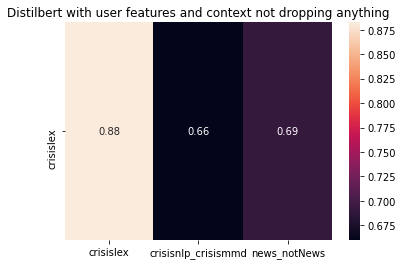

In [ ]:
sns.heatmap(df, annot=True).set_title('Distilbert with user features and context not dropping anything')
